<a href="https://colab.research.google.com/github/Andre-1970/Machine_learning_classical_algorithms_Sem4/blob/main/10_Homework_11_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)


# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<Axes: title={'center': 'Pearson Correlation of Features'}>

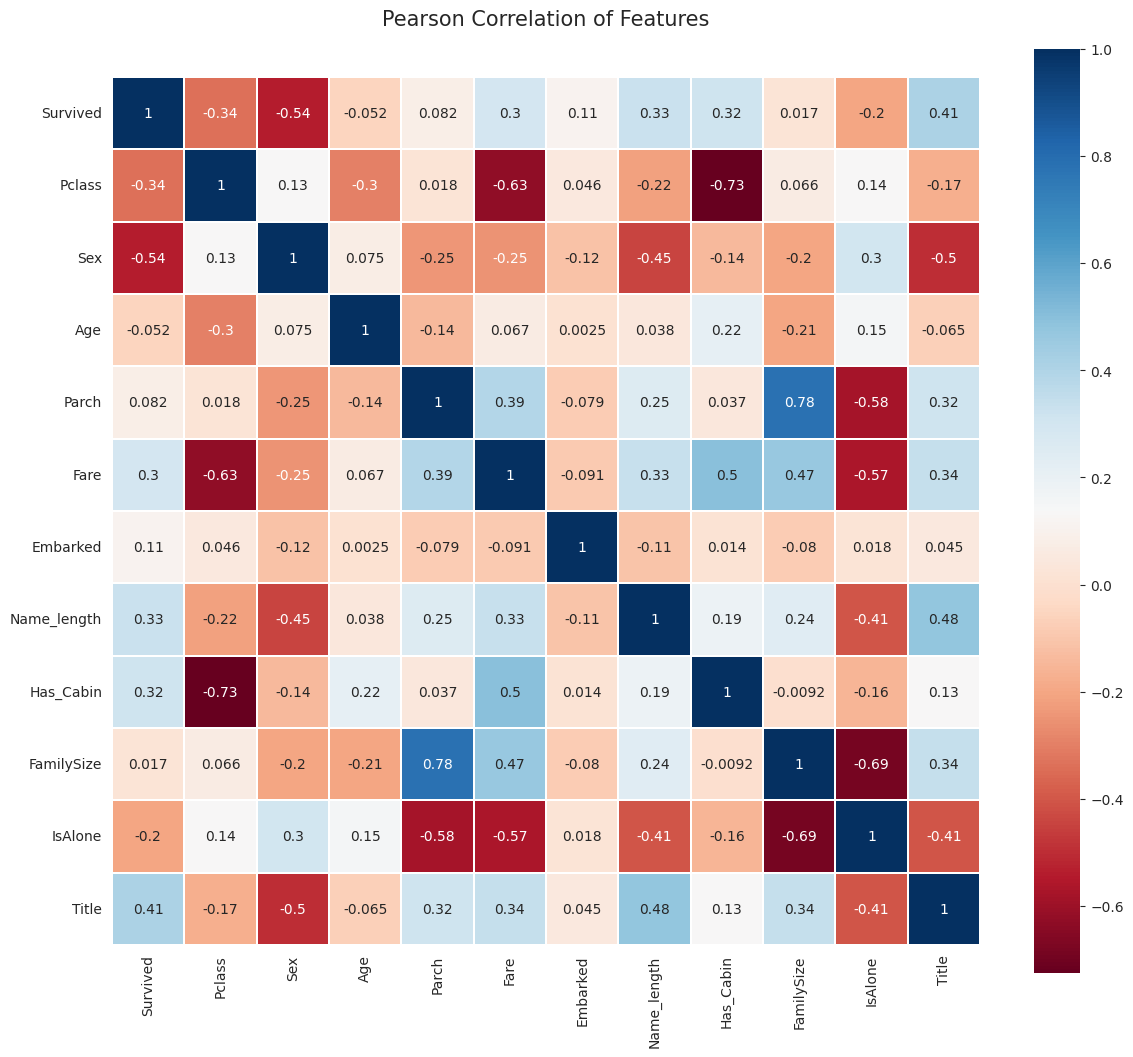

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

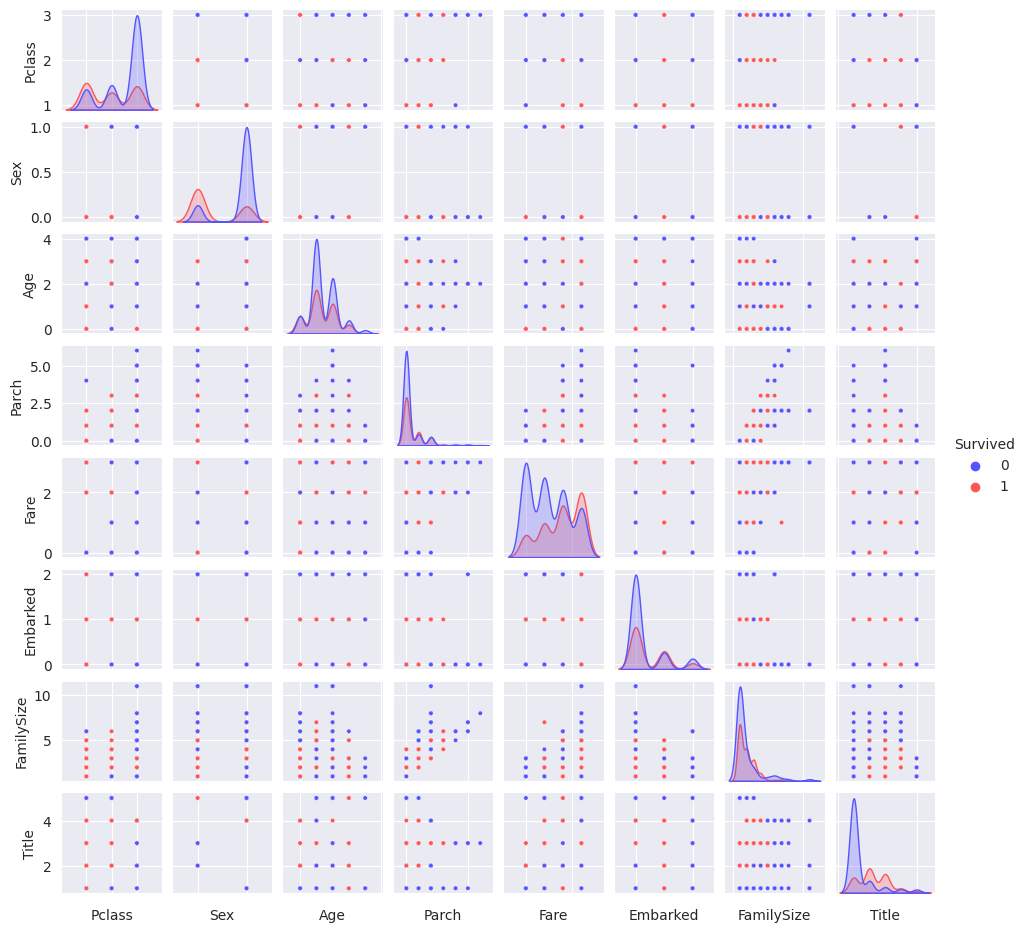

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette='seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict


def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None,
             test_size=None, cv=5):
    if test_size is None:
        meta_mtrx = np.zeros((len(data_train), len(models)))

        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
            model.fit(data_train, targets_train)

        meta_alg.fit(meta_mtrx, targets_train)

        meta_mtrx_test = np.zeros((len(data_test), len(models)))

        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)

        final_predictions = meta_alg.predict(meta_mtrx_test)

        if targets_test is not None:
            print("ROC AUC score:", roc_auc_score(targets_test, final_predictions))

    elif test_size > 0 and test_size < 1:
        # Разделение на тренировочные и валидационные данные
        train_data, valid_data, train_targets, valid_targets = train_test_split(data_train, targets_train,
                                                                                test_size=test_size,
                                                                                random_state=random_state)

        # Определение матрицы метапризнаков
        meta_mtrx = np.empty((valid_data.shape[0], len(models)))

        # Цикл для заполнения матрицы метапризнаков
        for n, model in enumerate(models):
            # Обучение базовой модели на тренировочных данных
            model.fit(train_data, train_targets)

            # Заполнение метапризнаков значениями предсказаний на валидационных данных
            meta_mtrx[:, n] = model.predict(valid_data)

        # Обучение мета-алгоритма на метапризнаках и целевой переменной для валидационных данных
        meta_alg.fit(meta_mtrx, valid_targets)

        # Определение матрицы метапризнаков для тестовых данных
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))

        # Цикл для заполнения матрицы метапризнаков для тестовых данных
        for n, model in enumerate(models):
            # Заполнение метапризнаков значениями предсказаний на тестовых данных
            meta_mtrx_test[:, n] = model.predict(data_test)

        # Предсказание мета-алгоритма на тестовых данных
        meta_predictions = meta_alg.predict(meta_mtrx_test)

        # Проверка качества модели на тестовых данных
        if targets_test is not None:
            auc = roc_auc_score(targets_test, meta_predictions)
            print(f"Test AUC: {auc}")

        return meta_predictions

    else:
        raise ValueError("test_size must be between 0 and 1")

In [9]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Разделение данных на тренировочные и валидационные наборы
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('Survived', axis=1), train['Survived'],
                                                      test_size=0.3, random_state=17)

# Параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)}
rfc_params = {'n_estimators': range(10, 100, 10), 'min_samples_leaf': range(1, 5)}
svc_params = {'kernel': ['linear', 'rbf'], 'C': np.arange(0.1, 1, 0.2)}
lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Настройка каждого базового алгоритма с помощью GridSearchCV
gbc = GridSearchCV(GradientBoostingClassifier(random_state=17), gbc_params, cv=skf)
rfc = GridSearchCV(RandomForestClassifier(random_state=17), rfc_params, cv=skf)
svc = GridSearchCV(SVC(random_state=17), svc_params, cv=skf)
lr = GridSearchCV(LogisticRegression(random_state=17), lr_params, cv=skf)

# Обучение базовых алгоритмов
gbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svc.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Создание списка базовых алгоритмов
models = [gbc, rfc, svc, lr]

# Инициализация мета-алгоритма
meta_alg = XGBClassifier(random_state=17)

# Применение функции стекинга
stacking(models, meta_alg, X_train.values, y_train.values, X_valid.values, y_valid.values, random_state=17,
         test_size=0.3)

Test AUC: 0.7974407528547656


array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [10]:
# Настройка каждого базового алгоритма с помощью GridSearchCV
gbc = GridSearchCV(GradientBoostingClassifier(random_state=17), gbc_params, cv=skf)
rfc = GridSearchCV(RandomForestClassifier(random_state=17), rfc_params, cv=skf)
svc = GridSearchCV(SVC(random_state=17), svc_params, cv=skf)
lr = GridSearchCV(LogisticRegression(random_state=17), lr_params, cv=skf)

In [11]:
gbc.fit(X_train, y_train)
print("GradientBoostingClassifier:")
print(f"Лучшие параметры: {gbc.best_params_}")
print(f"Лучшее качество: {gbc.best_score_:.4f}")

rfc.fit(X_train, y_train)
print("RandomForestClassifier:")
print(f"Лучшие параметры: {rfc.best_params_}")
print(f"Лучшее качество: {rfc.best_score_:.4f}")

svc.fit(X_train, y_train)
print("SVC:")
print(f"Лучшие параметры: {svc.best_params_}")
print(f"Лучшее качество: {svc.best_score_:.4f}")

lr.fit(X_train, y_train)
print("LogisticRegression:")
print(f"Лучшие параметры: {lr.best_params_}")
print(f"Лучшее качество: {lr.best_score_:.4f}")

GradientBoostingClassifier:
Лучшие параметры: {'learning_rate': 0.1}
Лучшее качество: 0.8298
RandomForestClassifier:
Лучшие параметры: {'min_samples_leaf': 2, 'n_estimators': 10}
Лучшее качество: 0.8426
SVC:
Лучшие параметры: {'C': 0.1, 'kernel': 'linear'}
Лучшее качество: 0.8042
LogisticRegression:
Лучшие параметры: {'C': 0.5}
Лучшее качество: 0.8121


In [12]:
gbc_pred = gbc.predict(X_valid)
gbc_auc = roc_auc_score(y_valid, gbc_pred)
print(f"GradientBoostingClassifier. ROC AUC: {gbc_auc:.4f}")

rfc_pred = rfc.predict(X_valid)
rfc_auc = roc_auc_score(y_valid, rfc_pred)
print(f"RandomForestClassifier. ROC AUC: {rfc_auc:.4f}")

svc_pred = svc.predict(X_valid)
svc_auc = roc_auc_score(y_valid, svc_pred)
print(f"SVC. ROC AUC: {svc_auc:.4f}")

lr_pred = lr.predict(X_valid)
lr_auc = roc_auc_score(y_valid, lr_pred)
print(f"LogisticRegression. ROC AUC: {lr_auc:.4f}")

GradientBoostingClassifier. ROC AUC: 0.7529
RandomForestClassifier. ROC AUC: 0.7696
SVC. ROC AUC: 0.7731
LogisticRegression. ROC AUC: 0.7813


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [13]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [14]:
# Применение функции стекинга
meta_mtrx = stacking(models, meta_alg,
                     X_train.values, y_train.values,
                     X_valid.values, y_valid.values,
                     random_state=17, test_size=0.3)

# Изменение размерности матрицы meta_mtrx
meta_mtrx = meta_mtrx.reshape(meta_mtrx.shape[0], -1)

# Инициализация мета-алгоритма и определение параметров для настройки
meta_alg = XGBClassifier(random_state=17)
meta_params = {'n_estimators': range(10, 100, 5), 'eta': np.arange(0.1, 1., .1),
               'min_child_weight': range(1, 10, 1), 'subsample': np.arange(0.1, 1., 0.2)}

# Настройка мета-алгоритма с помощью GridSearchCV
meta_alg_grid = GridSearchCV(meta_alg, meta_params, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc')
meta_alg_grid.fit(meta_mtrx, y_valid)

# Вывод результатов
print("Best score:", meta_alg_grid.best_score_)
print("Best parameters:", meta_alg_grid.best_params_)

Test AUC: 0.7974407528547656
Fitting 5 folds for each of 7290 candidates, totalling 36450 fits
Best score: 0.7972033182455693
Best parameters: {'eta': 0.1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.1}


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [23]:
# Подготовка тренировочных данных
data_train = train.drop('Survived', axis=1)
targets_train = train['Survived']

# Подготовка тестовых данных
test_data = test.values

# Обучение базовых моделей
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
rfc = RandomForestClassifier(n_estimators=10, min_samples_leaf=1, random_state=17)
svc = SVC(C=0.1, kernel='linear', random_state=17)
lr = LogisticRegression(C=0.5, random_state=17)

# Обучение базовых алгоритмов
gbc.fit(data_train, targets_train)
rfc.fit(data_train, targets_train)
svc.fit(data_train, targets_train)
lr.fit(data_train, targets_train)

# Создание списка базовых алгоритмов
models = [gbc, rfc, svc, lr]

# Определение матрицы метапризнаков
meta_mtrx = np.zeros((data_train.shape[0], len(models)))

# Заполнение метапризнаков значениями предсказаний на тренировочных данных
for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(data_train)

# Инициализация и обучение мета-алгоритма
meta_alg = XGBClassifier(n_estimators=10, eta=0.1, min_child_weight=1, subsample=0.1, random_state=17)
meta_alg.fit(meta_mtrx, targets_train)

# Определение матрицы метапризнаков для тестовых данных
meta_mtrx_test = np.zeros((test_data.shape[0], len(models)))

# Заполнение метапризнаков значениями предсказаний на тестовых данных
for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test_data)

# Прогнозирование мета-алгоритма на тестовых данных
meta_predictions = meta_alg.predict(meta_mtrx_test)

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [24]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [25]:
write_to_submission_file(meta_predictions, PassengerId, out_file='data/Submission.csv', columns=['PassengerId', 'Survived'])

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:
